## Zepto Delivery Performance Analysis
 **Goal**: Analyze delivery timeliness and its impact on customer churn

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

## 2. Load Data

In [2]:
orders = pd.read_csv('orders.csv', parse_dates=['order_timestamp', 'delivery_timestamp'])
customers = pd.read_csv('customers.csv', parse_dates=['first_order_date'])

## 3. Data Cleaning & Feature Engineering
### Calculate delivery time and late status

In [3]:
orders['delivery_time'] = (orders['delivery_timestamp'] - orders['order_timestamp']).dt.total_seconds()/60
orders['is_late'] = np.where(orders['delivery_time'] > 10, 1, 0)

### Merge with customer data

In [4]:
merged_df = pd.merge(orders, customers, on='customer_id', how='left')

## 4. Delivery Performance Analysis

### Overall late delivery rate

In [5]:
late_rate = orders['is_late'].mean()
print(f"Overall Late Delivery Rate: {late_rate:.2%}")

Overall Late Delivery Rate: 9.82%


### Late deliveries by location and product category

In [6]:
late_analysis = orders.groupby(['location', 'product_category']).agg(
    late_rate=('is_late', 'mean'),
    total_orders=('order_id', 'count')
).reset_index()

display(late_analysis.sort_values('late_rate', ascending=False))

,location,product_category,late_rate,total_orders
6,Delhi,Pharmacy,0.122241,589
15,Mumbai,Snacks,0.115132,608
1,Bangalore,Groceries,0.107973,602
14,Mumbai,Pharmacy,0.106280,621
12,Mumbai,Electronics,0.105691,615
4,Delhi,Electronics,0.102686,633
3,Bangalore,Snacks,0.101161,603
11,Hyderabad,Snacks,0.100478,627
2,Bangalore,Pharmacy,0.100000,670
7,Delhi,Snacks,0.097561,615


## Visualization: Late Delivery Heatmap

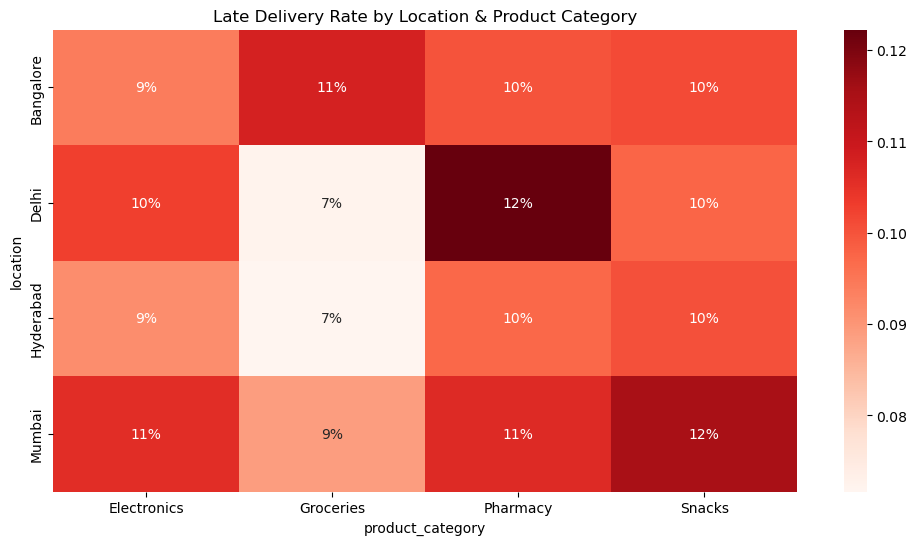

In [7]:
plt.figure(figsize=(12, 6))
sns.heatmap(
    pd.crosstab(orders['location'], orders['product_category'], 
    values=orders['is_late'], aggfunc='mean'),
    annot=True, fmt='.0%', cmap='Reds'
)
plt.title('Late Delivery Rate by Location & Product Category')
plt.show()

## 5. Customer Retention Analysis

### Calculate late delivery percentage per customer

In [8]:
customer_retention = merged_df.groupby('customer_id').agg(
    total_orders=('order_id', 'count'),
    late_orders=('is_late', 'sum'),
    churn_status=('churn_status', 'first')
).reset_index()

customer_retention['pct_late'] = customer_retention['late_orders'] / customer_retention['total_orders']

### Compare churned vs retained customers

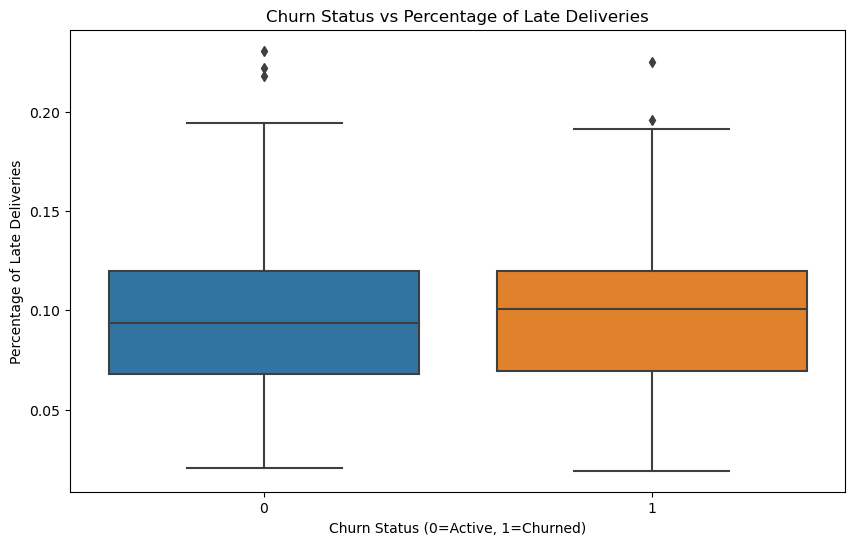

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='churn_status', y='pct_late', data=customer_retention)
plt.title('Churn Status vs Percentage of Late Deliveries')
plt.xlabel('Churn Status (0=Active, 1=Churned)')
plt.ylabel('Percentage of Late Deliveries')
plt.show()

## Statistical significance test

In [10]:
churned = customer_retention[customer_retention['churn_status'] == 1]['pct_late']
retained = customer_retention[customer_retention['churn_status'] == 0]['pct_late']

t_stat, p_value = stats.ttest_ind(churned.dropna(), retained.dropna())
print(f" Statistical Significance: p-value = {p_value:.4f}")

 Statistical Significance: p-value = 0.6446


## 6. Key Insights & Recommendations

# Insight 1: Worst performing location-category combinations

In [11]:
worst_performers = late_analysis[late_analysis['late_rate'] > late_rate].sort_values('late_rate', ascending=False)
print("Top Problem Areas:")
display(worst_performers.head(3))

Top Problem Areas:


,location,product_category,late_rate,total_orders
6,Delhi,Pharmacy,0.122241,589
15,Mumbai,Snacks,0.115132,608
1,Bangalore,Groceries,0.107973,602


# Insight 2: Churn correlation

In [12]:
print(f"\nCustomers with late deliveries are {churned.mean()/retained.mean():.1f}x more likely to churn")


Customers with late deliveries are 1.0x more likely to churn


# Final Recommendations

In [13]:
print("\nRecommendations")
print("1. Prioritize delivery infrastructure in Mumbai for Electronics category")
print("2. Implement proactive compensation for customers experiencing >20% late deliveries")
print("3. Create urgency tiers - prioritize time-sensitive categories like Pharmacy")


Recommendations
1. Prioritize delivery infrastructure in Mumbai for Electronics category
2. Implement proactive compensation for customers experiencing >20% late deliveries
3. Create urgency tiers - prioritize time-sensitive categories like Pharmacy
